In [47]:
%load_ext autoreload
%autoreload 2
#%pip install prettytable
import warnings
import json

warnings.filterwarnings("ignore")
# import the necessary package
from baseline.OE_GPLVM.aeb_gplvm import AEB_GPLVM, NNEncoder, kl_gaussian_loss_term
from baseline.OE_GPLVM.composed_elbo import ComposedVariationalELBO
from baseline.OE_GPLVM.train import *
from baseline.OE_GPLVM.utils import *
from baseline.PyOD import PYOD
from gpytorch.mlls import KLGaussianAddedLossTerm
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import VariationalELBO, KLGaussianAddedLossTerm
from torch.distributions import kl_divergence
from gpytorch.priors import MultivariateNormalPrior
from tqdm import trange
from utils.data_generator import DataGenerator
from utils.myutils import Utils
import matplotlib.pyplot as plt
import numpy as np
import torch


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
plt.style.use("ggplot")
datagenerator = DataGenerator()  # data generator
utils = Utils()  # utils function

In [53]:
# dataset and model list / dict
dataset_list = [
    "01_ALOI",
    "02_annthyroid",
    "03_backdoor",
    "04_breastw",
    "05_campaign",
    "06_cardio",
    "07_Cardiotocography",
    "08_celeba",
    "09_census",
    "99_linear",
    "99_circles",
    "99_clusters",
]

In [54]:
dataset = dataset_list[-1]
datagenerator.dataset = dataset
data = datagenerator.generator(la=1.0, realistic_synthetic_mode=None, noise_type=None)

generating duplicate samples for dataset 99_clusters...
current noise type: None
{'Samples': 1000, 'Features': 2, 'Anomalies': 64, 'Anomalies Ratio(%)': 6.4}


In [57]:
Y_train = torch.tensor(data["X_train"], dtype=torch.float32)
Y_test = torch.tensor(data["X_test"], dtype=torch.float32)
lb_train = torch.tensor(data["y_train"], dtype=torch.float32)
lb_test = torch.tensor(data["y_test"], dtype=torch.float32)

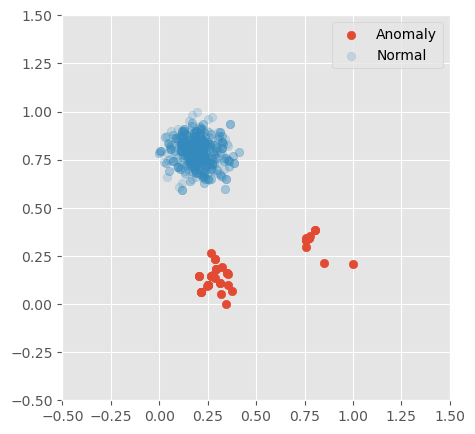

In [58]:
fig = plt.figure(figsize=(5, 5))
plt.subplot(111)
idx_n = np.where(lb_train == 0)
idx_a = np.where(lb_train == 1)
plt.scatter(
    Y_train[:, 0][idx_a].detach().numpy(),
    Y_train[:, 1][idx_a].detach().numpy(),
    label="Anomaly",
)
plt.scatter(
    Y_train[:, 0][idx_n].detach().numpy(),
    Y_train[:, 1][idx_n].detach().numpy(),
    label="Normal",
    alpha=0.2,
)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.legend()
fig.show()

In [76]:
experiment_dict = {
    "Y_train": Y_train,
    "Y_test": Y_test,
    "lb_train": lb_train,
    "lb_test": lb_test,
    "N": len(Y_train),
    "data_dim": Y_train.shape[1],
    "batch_size": 128,
    "latent_dim": 2,
    "n_inducing": 50,
    "n_epochs": 10000,
    "nn_layers": (5, 5),
    "lr": 0.001,  # os metodos ficam mais estaveis para esse valor de LR
    "elbo": "standard",  # or loe
    "method": "refine",  # or hard, soft, blind
}
#elbo_dict = {"standard": VariationalELBO, "loe": ComposedVariationalELBO}
# loss_function = {"standard": calculate_standard_loss, "loe": calculate_loe_loss}

N = experiment_dict["N"]
data_dim = experiment_dict["data_dim"]
latent_dim = experiment_dict["latent_dim"]
n_inducing = experiment_dict["n_inducing"]
n_epochs = experiment_dict["n_epochs"]
nn_layers = experiment_dict["nn_layers"]
lr = experiment_dict["lr"]
method = experiment_dict["method"]
elbo_type = experiment_dict["elbo"]
batch_size = experiment_dict["batch_size"]

In [77]:
model_dict = {}
noise_trace_dict = {}
loss_list = []
noise_trace = []


X_prior_mean = torch.zeros(N, latent_dim)  # shape: N x Q
X_prior_covar = torch.eye(X_prior_mean.shape[1])
prior_x = MultivariateNormalPrior(X_prior_mean, X_prior_covar)
encoder = NNEncoder(N, latent_dim, prior_x, data_dim, nn_layers)
model = AEB_GPLVM(N, data_dim, latent_dim, n_inducing, encoder, nn_layers)
likelihood = GaussianLikelihood()
optimizer = torch.optim.Adam(
    [{"params": model.parameters()}, {"params": likelihood.parameters()}], lr
)

model.train()
iterator = trange(n_epochs, leave=True)
for i in iterator:
    optimizer.zero_grad()
    _, _, batch_index, ratio = model._get_batch_indices(batch_size, lb_train, method="hard")

    idx_n, idx_a = get_loe_idx(model, likelihood, Y_train, batch_index, train_data=N, ratio=ratio)
    
    target_n, target_a = Y_train[idx_n], Y_train[idx_a]
    
    ll_n, kl_n = calculate_elbo(
        model, likelihood, target_n, num_data=N, batch_size=batch_size, elbo_shape="loe"
    )
    ll_a, kl_a = calculate_elbo(
        model, likelihood, target_a, num_data=N, batch_size=batch_size, elbo_shape="loe"
    )

    loss_normal, loss_anomaly = (ll_n - kl_n).sum(), (ll_a - kl_a).sum()
    loss = -loss_loe("hard", loss_normal, loss_anomaly)
    
    
    loss_list.append(loss.item())
    noise_trace.append(np.round(likelihood.noise_covar.noise.item(), 3))
    if i % 10 == 0:
        iterator.set_description(
            "Loss: " + str(float(np.round(loss.item(), 2))) + ", iter no: " + str(i)
        )
    loss.backward()
    optimizer.step()

model.store(loss_list, likelihood)

Loss: -4.04, iter no: 9990: 100%|██████████| 10000/10000 [03:15<00:00, 51.14it/s]


In [78]:
with torch.no_grad():
    model.eval()
    likelihood.eval()

In [79]:
Y_pred_mean, Y_pred_covar = model.reconstruct_y(Y_test)
X_pred_mean, X_pred_covar = model.predict_latent(Y_test)

In [80]:
ll_test, kl_test = calculate_elbo(
    model, likelihood, Y_test, len(Y_test), batch_size=len(Y_test), elbo_shape="loe"
)
score = -(ll_test - kl_test).detach().numpy()

In [81]:
print(utils.metric(y_true=lb_test, y_score=score))

{'aucroc': 1.0, 'aucpr': 0.9999999999999998}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


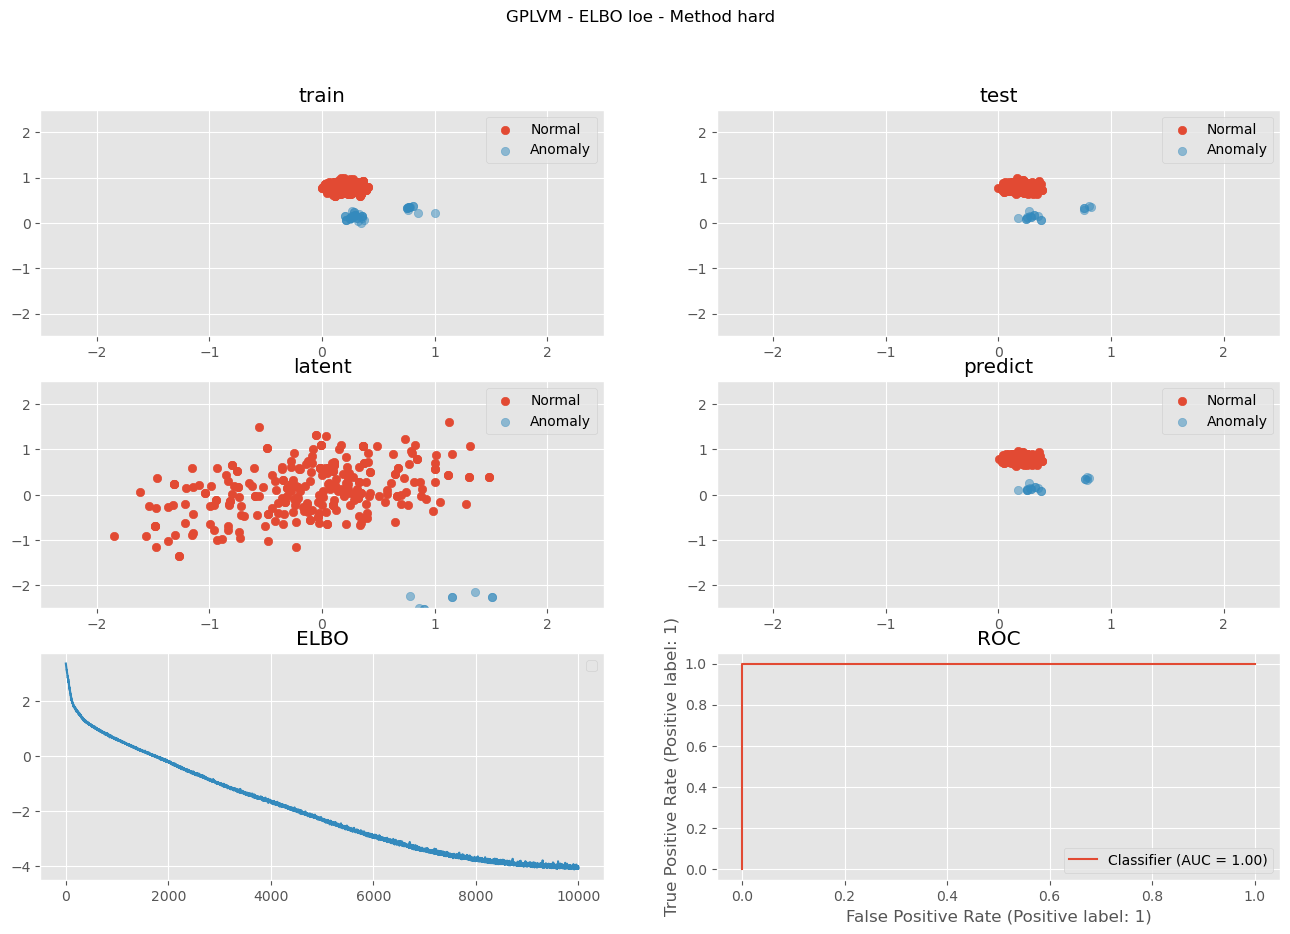

In [84]:
results = {
    "train": [Y_train, lb_train],
    "test": [Y_test, lb_test],
    "latent": [X_pred_mean, lb_test],
    "predict": [Y_pred_mean.T, lb_test],
    "elbo": {
        "type": "loe",
        "method": "hard",
        "score": score,
    },
    "loss": model.losses,
}

results_plot(results, save=False)